# Calculo de incertidumbre para modelos de regresión

## Introducción

En este notebook se van a presentar diferentes datasets con drifts en posiciones conocidas. Para cada dataset se va a mostrar la evolución de la incertidumbre, calculada según diferentes métodos. El objetivo consiste en encontrar una relación entre aumento de incertidumbre y la aparición de drift. 



## Cargar Librerias



In [1]:
!pip install nonconformist river numpy==1.23.5


import numpy as np
import pandas as pd
from scipy.stats import t
from functools import reduce
from river import preprocessing
from river import linear_model
from river import optim
import matplotlib.pyplot as plt
from nonconformist.cp import IcpRegressor
from nonconformist.nc import RegressorNc, RegressorAdapter, AbsErrorErrFunc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, PassiveAggressiveRegressor
from sklearn.tree import DecisionTreeRegressor

random_state = np.random.RandomState(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Datasets





### Funciones de apoyo

In [2]:
def generateRegressionDataSet(intercept=[1,0], domain=range(0,100), noise=[0 for x in range(0,100)], columns=['x', 'y']):
  data = []
  for x, single_noise in zip(domain, noise):
    data.append([x, x*intercept[0]+intercept[1]+ single_noise])
  return pd.DataFrame(data, columns=columns)

def mergeDataSetsSudden(dataset1, dataset2):
  res = []
  for data in dataset1.values.tolist():
    res.append(data)
  for data in dataset2.values.tolist():
    res.append(data)
  return pd.DataFrame(data=res, columns=dataset1.columns)

def generateRegressionDataSetWithSuddenDrift(intercept, domain=[range(0,100), range(100,200)], noise=[[0 for x in range(0,100)], [0 for x in range(0,100)]], columns=['x', 'y']):
  datasets = []
  for d in zip(domain, noise, intercept):
    dataset = generateRegressionDataSet(intercept=d[2], domain=d[0], noise=d[1], columns=columns)
    datasets.append(dataset)
  return reduce(mergeDataSetsSudden, datasets)

def generateRegressionWithGradualDrift(intercept, domain=[range(0,130), range(70,200)], transition_in=[1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,1,0,0], transition_out=[0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0,0,1,1], noise=[[0 for x in range(0,130)], [0 for x in range(0,130)]], columns=['x', 'y']):
  datasets = []
  for d in zip(domain, noise, intercept):
    dom = [x for index, x in enumerate(d[0]) if ((index < len(transition_in) and transition_in[index] == 1) or (index > len(transition_in) and index<len(d[0])-len(transition_out)) or (index>len(d[0])-len(transition_out) and transition_out[index - len(d[0])+len(transition_out)] == 1))] 
    nos = [x for index, x in enumerate(d[1]) if ((index < len(transition_in) and transition_in[index] == 1) or (index > len(transition_in) and index<len(d[1])-len(transition_out)) or (index>len(d[1])-len(transition_out) and transition_out[index - len(d[1])+len(transition_out)] == 1))] 
    dataset = generateRegressionDataSet(intercept=d[2], domain=dom, noise=nos, columns=columns)
    datasets.append(dataset)    
  return reduce(mergeDataSetsSudden, datasets) 

def mergeDataSetsIncremental(dataset1, dataset2, combine_fn, steps=20):
  res = []
  for data in dataset1.values.tolist()[0:len(dataset1)-steps]:
    res.append(data)
  for i in range(0,steps):
    item1 = dataset1.values.tolist()[len(dataset1)-steps + i]
    item2 = dataset2.values.tolist()[i]
    res.append(combine_fn(item1, item2, i, steps))
  for data in dataset2.values.tolist()[steps:]:
    res.append(data)
  return pd.DataFrame(data=res, columns=dataset1.columns)

def generateRegressionDataSetWithIncrementalDrift(intercept, combine_fn, domain=[range(0,110), range(90,200)], noise=[[0 for x in range(0,110)], [0 for x in range(0,110)]], columns=['x', 'y']):
  datasets = []
  for d in zip(domain, noise, intercept):
    dataset = generateRegressionDataSet(intercept=d[2], domain=d[0], noise=d[1], columns=columns)
    datasets.append(dataset)
  return reduce(lambda d1, d2: mergeDataSetsIncremental(d1, d2, combine_fn=combine_fn, steps=20), datasets)

def normalizeData(dataset):
  return (dataset-dataset.mean())/dataset.std()


### Dataset 1

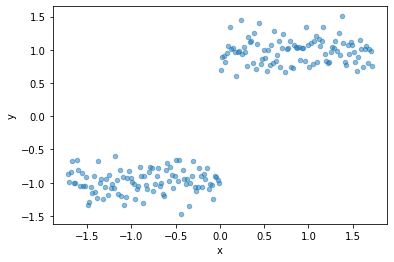

In [3]:
dataset1 = normalizeData(generateRegressionDataSetWithSuddenDrift(intercept=[[0,10], [0,30]], noise=[random_state.normal(0,2, 100), random_state.normal(0,2, 100)]))
dataset1.plot.scatter(x='x', y='y', alpha=0.5)

### Dataset 2

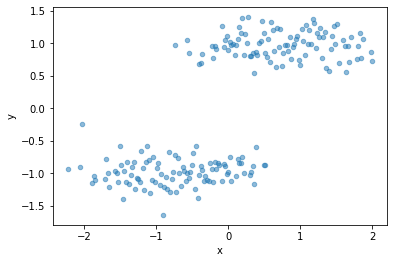

In [4]:
dataset2 = normalizeData(generateRegressionWithGradualDrift(intercept=[[0,10], [0,30]], noise=[random_state.normal(0,2, 130), random_state.normal(0,2, 130)]))
dataset2.plot.scatter(x='x', y='y', alpha=0.5)

### Dataset 3

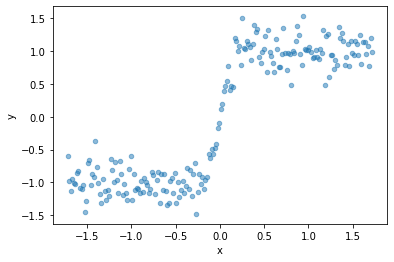

In [5]:
dataset3 = normalizeData(generateRegressionDataSetWithIncrementalDrift(intercept=[[0,10], [0,30]], combine_fn=lambda item1, item2, pos, steps: [item1[0], (1 - pos/steps)*item1[1] + (pos/steps)*item2[1]], noise=[random_state.normal(0,2, 130), random_state.normal(0,2, 130)]))
dataset3.plot.scatter(x='x', y='y', alpha=0.5)

### Dataset 4

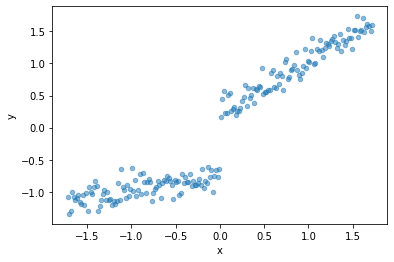

In [6]:
dataset4 = normalizeData(generateRegressionDataSetWithSuddenDrift(intercept=[[1,0], [4,0]], noise=[random_state.normal(0,40, 100), random_state.normal(0,40, 100)]))
dataset4.plot.scatter(x='x', y='y', alpha=0.5)

### Dataset 5

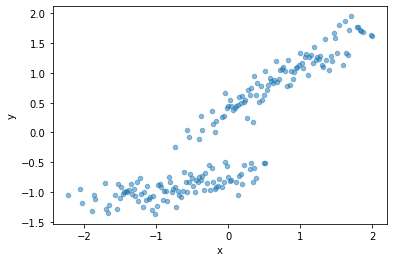

In [7]:
dataset5 = normalizeData(generateRegressionWithGradualDrift(intercept=[[1,0], [4,0]], noise=[random_state.normal(0,40, 130), random_state.normal(0,40, 130)]))
dataset5.plot.scatter(x='x', y='y', alpha=0.5)

### Dataset 6

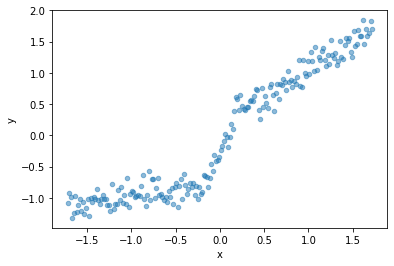

In [8]:
dataset6 = normalizeData(generateRegressionDataSetWithIncrementalDrift(intercept=[[1,0], [4,0]], combine_fn=lambda item1, item2, pos, steps: [item1[0], (1 - pos/steps)*item1[1] + (pos/steps)*item2[1]], noise=[random_state.normal(0,40, 130), random_state.normal(0,40, 130)]))
dataset6.plot.scatter(x='x', y='y', alpha=0.5)

### Dataset 7

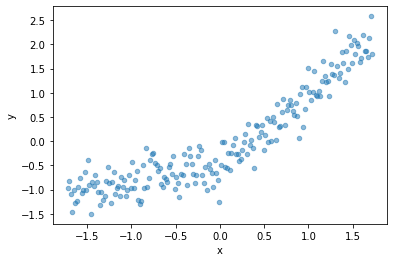

In [9]:
dataset7 = normalizeData(generateRegressionDataSetWithSuddenDrift(intercept=[[1,0], [4,-300]], noise=[random_state.normal(0,40, 100), random_state.normal(0,40, 100)]))
dataset7.plot.scatter(x='x', y='y', alpha=0.5)

### Dataset 8

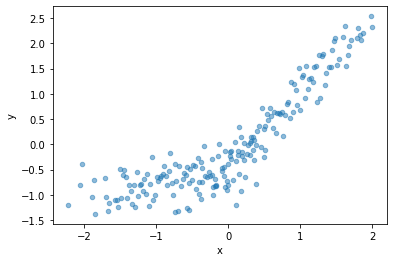

In [10]:
dataset8 = normalizeData(generateRegressionWithGradualDrift(intercept=[[1,0], [4,-300]], noise=[random_state.normal(0,40, 130), random_state.normal(0,40, 130)]))
dataset8.plot.scatter(x='x', y='y', alpha=0.5)

### Dataset 9

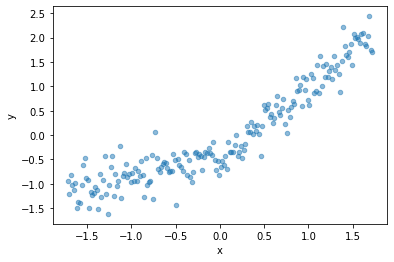

In [11]:
dataset9 = normalizeData(generateRegressionDataSetWithIncrementalDrift(intercept=[[1,0], [4,-300]], combine_fn=lambda item1, item2, pos, steps: [item1[0], (1 - pos/steps)*item1[1] + (pos/steps)*item2[1]], noise=[random_state.normal(0,40, 130), random_state.normal(0,40, 130)]))
dataset9.plot.scatter(x='x', y='y', alpha=0.5)

## Métodos de cálculo de incertidumbre para regresión


### Cálculo de incertidumbre por cuartiles

#### Implementación

In [12]:
def getUncertaintyByQuantiles(dataset):
  sorted_dataset = dataset.sort_values(by=['x'])
  X = list(map(lambda x: {'x': x}, sorted_dataset['x']))
  Y =  sorted_dataset['y'].values.tolist()
  model = preprocessing.StandardScaler() | linear_model.LinearRegression(optimizer=optim.Adam())

  uncert = { 
      'uncert95': preprocessing.StandardScaler() | preprocessing.TargetStandardScaler(
          regressor=linear_model.LinearRegression(intercept_lr=0, optimizer=optim.SGD(0.03), loss=optim.losses.Quantile(alpha=0.95))),
      'uncert05': preprocessing.StandardScaler() | preprocessing.TargetStandardScaler(
          regressor=linear_model.LinearRegression(intercept_lr=0, optimizer=optim.SGD(0.03), loss=optim.losses.Quantile(alpha=0.05)))
  }
  res = {'x': [], 'y':[], 'uncert95': [], 'uncert05':[], 'metric': [], 'y_pred':[]}
  
  for x,y in zip(X,Y):
    res.get('x').append(x.get('x'))
    res.get('y').append(y)
    y_pred = model.predict_one(x)
    res.get('y_pred').append(y_pred)
    model.learn_one(x,y)


    for key in uncert.keys():
      uncert_model = uncert.get(key)
      y_pred = uncert_model.predict_one(x)
      res.get(key).append(y_pred)
      uncert_model.learn_one(x,y)
  return res


def showUncertainty(data, drifts=[], titles=['', '', '']):
  diff = []
  for u95, u05 in zip(data.get('uncert95'), data.get('uncert05')):
    diff.append(u95-u05)
   
  fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
  ax[0].scatter(data.get('x'), data.get('y'), color="blue", label="y_true", alpha=0.5)
  ax[0].plot(data.get('x'), data.get('y_pred'), color="orange", label="y_pred", alpha=0.5)
  ax[0].legend()
  ax[0].set_title(titles[0]+" Prediction")
  for drift in drifts:
    ax[0].axvline(x=drift, color='red')
  ax[1].fill_between(x = data.get('x'), y1 = data.get('uncert05'), y2 = data.get('uncert95'), alpha=0.5, label="intervalo incertidumbre")
  ax[1].plot(data.get('x'), data.get('y_pred'), color="orange", label="y_pred", alpha=0.5)
  ax[1].plot(data.get('x'), data.get('uncert05'), color="blue")
  ax[1].plot(data.get('x'), data.get('uncert95'), color="blue")
  ax[1].legend()
  ax[1].set_title(titles[1]+ " Prediction Interval")
  for drift in drifts:
    ax[1].axvline(x=drift, color='red')
  ax[2].fill_between(x= data.get('x'), y1=0, y2=diff, label="incertidumbre", alpha=0.5)
  ax[2].plot(data.get('x'), diff, color="blue")
  ax[2].legend()
  for drift in drifts:
    ax[2].axvline(x=drift, color='red')
  ax[2].set_title(titles[2]+ " Uncertainty")

def showUncertaintyByQuantiles(dataset, drifts = [], titles=['', '', '']):
  data = getUncertaintyByQuantiles(dataset)
  showUncertainty(data, drifts, titles)

#### Dataset 1

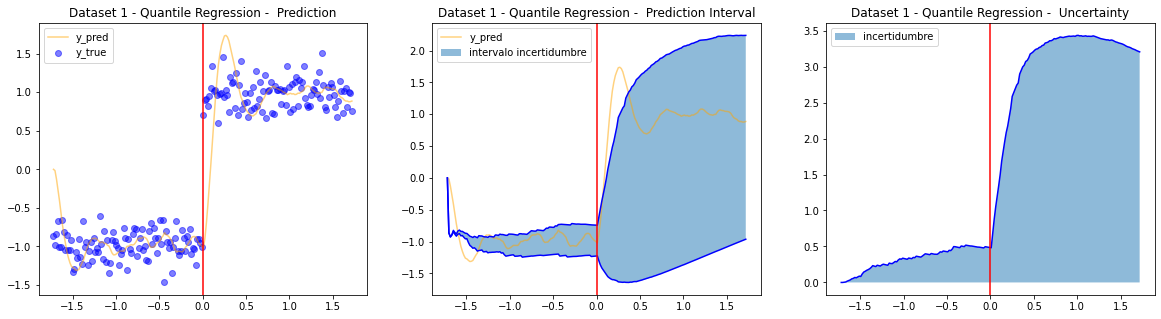

In [13]:
showUncertaintyByQuantiles(dataset1, drifts=[0], titles=['Dataset 1 - Quantile Regression - ', 'Dataset 1 - Quantile Regression - ', 'Dataset 1 - Quantile Regression - '])


#### Dataset 2

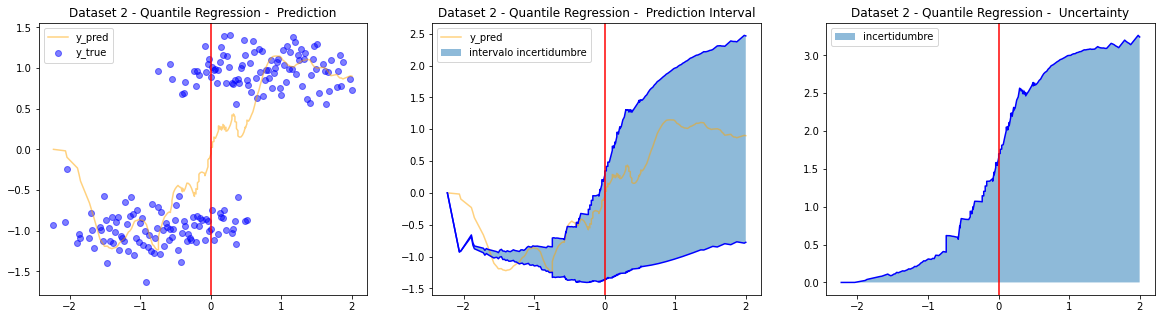

In [14]:
showUncertaintyByQuantiles(dataset2, drifts=[0], titles=['Dataset 2 - Quantile Regression - ', 'Dataset 2 - Quantile Regression - ', 'Dataset 2 - Quantile Regression - '])

#### Dataset 3

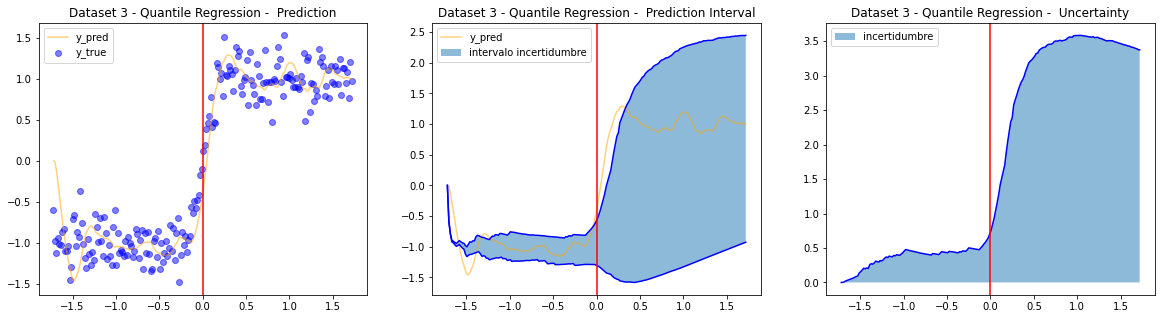

In [15]:
showUncertaintyByQuantiles(dataset3, drifts=[0], titles=['Dataset 3 - Quantile Regression - ', 'Dataset 3 - Quantile Regression - ', 'Dataset 3 - Quantile Regression - '])

#### Dataset 4

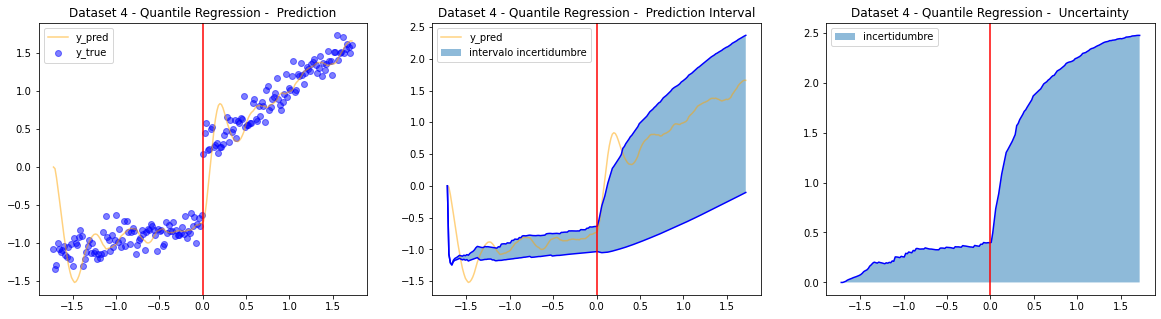

In [16]:
showUncertaintyByQuantiles(dataset4, drifts=[0], titles=['Dataset 4 - Quantile Regression - ', 'Dataset 4 - Quantile Regression - ', 'Dataset 4 - Quantile Regression - '])

#### Dataset 5

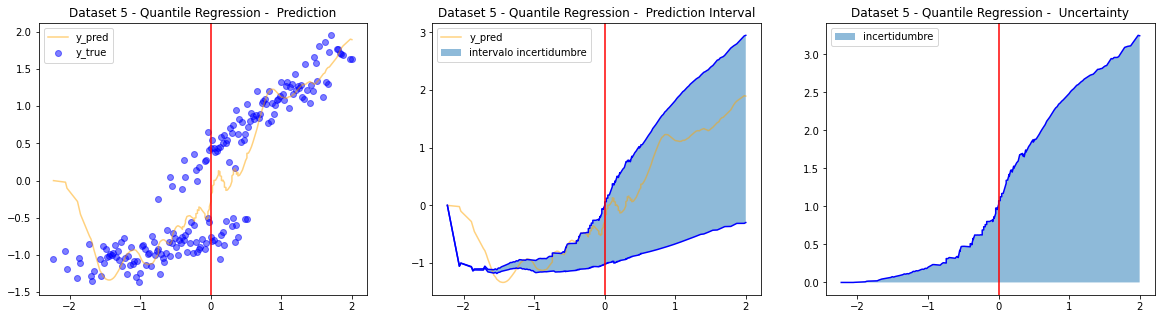

In [17]:
showUncertaintyByQuantiles(dataset5, drifts=[0], titles=['Dataset 5 - Quantile Regression - ', 'Dataset 5 - Quantile Regression - ', 'Dataset 5 - Quantile Regression - '])

#### Dataset 6

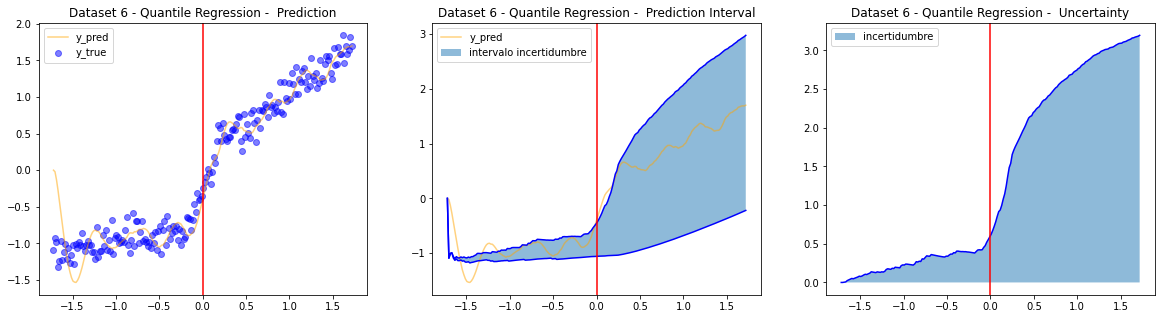

In [18]:
showUncertaintyByQuantiles(dataset6, drifts=[0], titles=['Dataset 6 - Quantile Regression - ', 'Dataset 6 - Quantile Regression - ', 'Dataset 6 - Quantile Regression - '])

#### Dataset 7

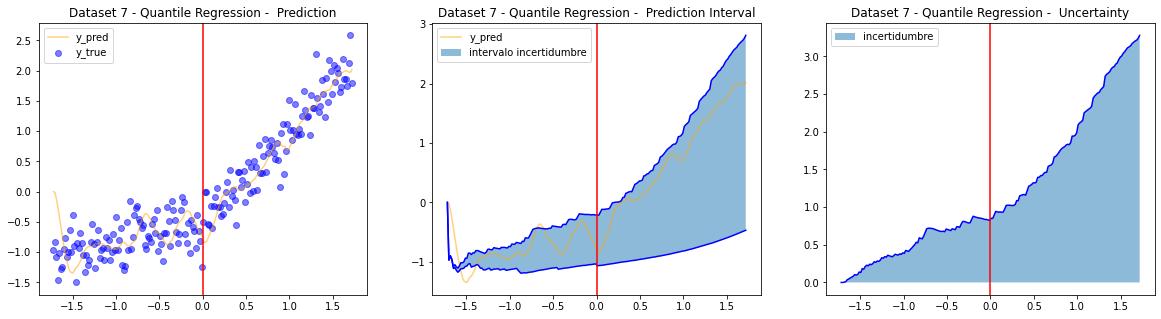

In [19]:
showUncertaintyByQuantiles(dataset7, drifts=[0], titles=['Dataset 7 - Quantile Regression - ', 'Dataset 7 - Quantile Regression - ', 'Dataset 7 - Quantile Regression - '])

#### Dataset 8

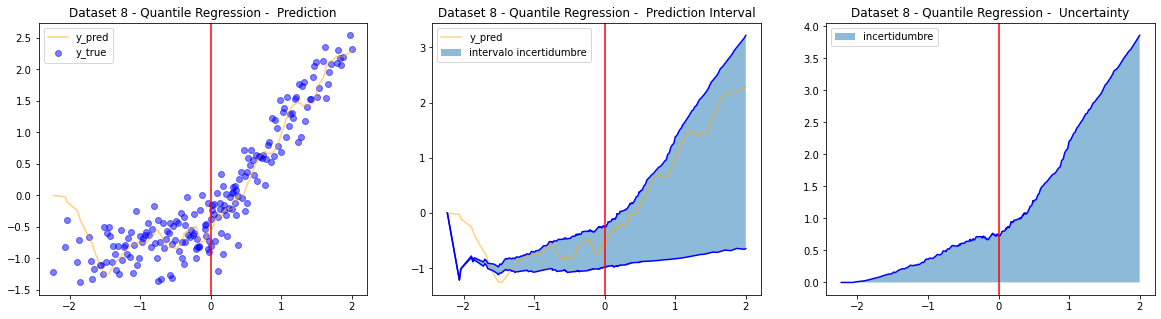

In [20]:
showUncertaintyByQuantiles(dataset8, drifts=[0], titles=['Dataset 8 - Quantile Regression - ', 'Dataset 8 - Quantile Regression - ', 'Dataset 8 - Quantile Regression - '])

#### Dataset 9

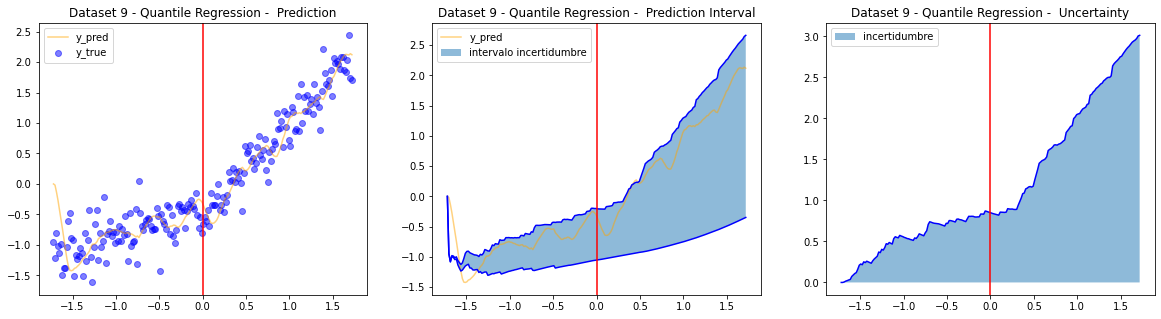

In [21]:
showUncertaintyByQuantiles(dataset9, drifts=[0], titles=['Dataset 9 - Quantile Regression - ', 'Dataset 9 - Quantile Regression - ', 'Dataset 9 - Quantile Regression - '])

### Cálculo de incertidumbre NonConformist


#### Implementación

In [22]:
def getUncertaintyByNC(dataset, model):
  sorted_dataset = dataset.sort_values(by=['x'])
  target = np.array(sorted_dataset['y']).flatten()
  data = np.array(sorted_dataset.drop(columns='y').values.tolist())

  train_data, test_data, train_target, test_target = train_test_split(data, target, train_size=0.7, shuffle=False)
  cal_data, test_data, cal_target, test_target = train_test_split(test_data, test_target, train_size=1/3, shuffle=False)



  res = {'x': data.flatten().tolist(), 'y':target.tolist(), 'uncert95': [], 'uncert05':[], 'metric': [0 for x in range(len(dataset.index))], 'y_pred':[]}

  

  # Default nonconformity measure
  nc = RegressorNc(RegressorAdapter(model), AbsErrorErrFunc())
  # Inductive conformal regressor
  icp = IcpRegressor(nc)
  # Fit the ICP using the proper training set
  icp.fit(train_data, train_target)
  # Calibrate the ICP using the calibration set
  icp.calibrate(cal_data, cal_target)
  # Desired coverage
  confidence = 0.95
  # Produce predictions for the test set
  prediction = icp.predict(data, significance=(1-confidence))
  res['uncert05'] = prediction[:, 0].tolist()
  res['uncert95'] = prediction[:, 1].tolist()
  res['y_pred'] = model.predict(data).tolist()
  return res

def mergeDict(a,b):
  for key, value in b.items():
    if key in a:
        a[key].extend(value)
    else:
        a[key] = value
  return a

def getUncertaintyByNCOnline(dataset, model):
  count = 25
  dataframes = []
  index_to_split = len(dataset) // count
  start = 0
  end = index_to_split
  for split in range(count):
    temporary_df = dataset.iloc[max(0, start-5*index_to_split):end, :]
    dataframes.append(temporary_df)
    start += index_to_split
    end += index_to_split
    

  data = list(map(lambda d: getUncertaintyByNC(d, model), dataframes))
  data = list(map(lambda d: {'x': [d['x'][-1]], 'y':[d['y'][-1]], 'uncert95': [d['uncert95'][-1]], 'uncert05': [d['uncert05'][-1]], 'metric': [d['metric'][-1]], 'y_pred':[d['y_pred'][-1]] }, data))
  single_data = reduce(mergeDict, data)
  df = pd.DataFrame(single_data)
  return df.sort_values(by=['x'])


#### Dataset 1

##### Linear Regression

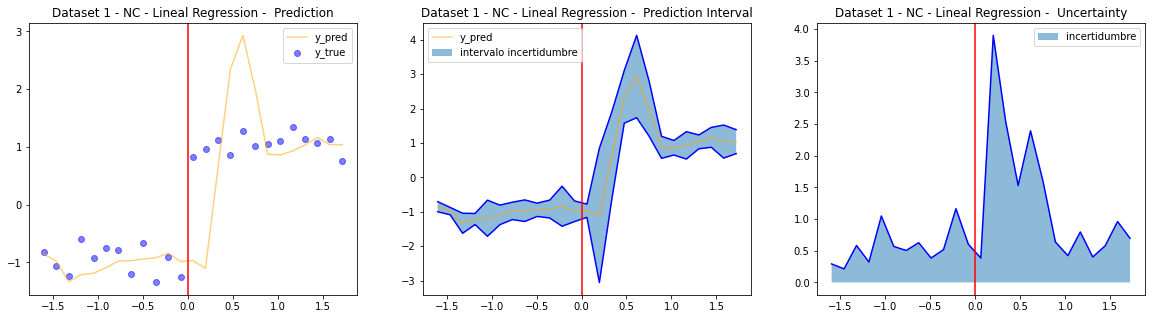

In [23]:
showUncertainty(getUncertaintyByNCOnline(dataset1, model = LinearRegression()), drifts=[0], titles=['Dataset 1 - NC - Lineal Regression - ', 'Dataset 1 - NC - Lineal Regression - ', 'Dataset 1 - NC - Lineal Regression - '])
  

##### PassiveAgressive Regression

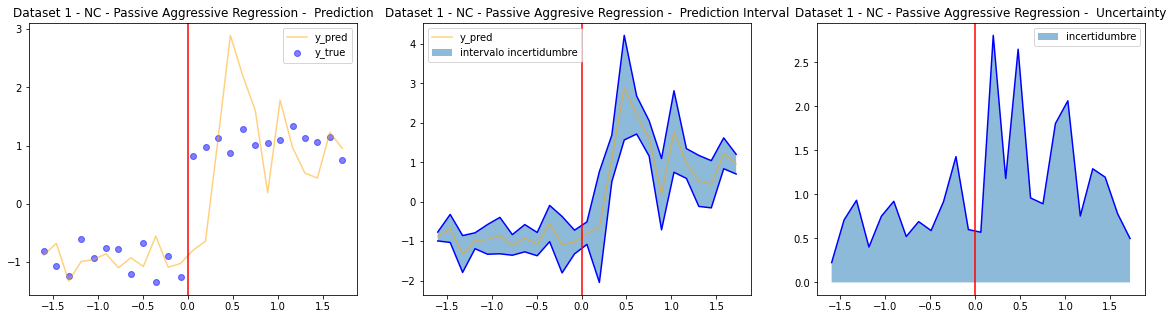

In [24]:
showUncertainty(getUncertaintyByNCOnline(dataset1, model = PassiveAggressiveRegressor()), drifts=[0], titles=['Dataset 1 - NC - Passive Aggressive Regression - ', 'Dataset 1 - NC - Passive Aggresive Regression - ', 'Dataset 1 - NC - Passive Aggressive Regression - '])
 

##### Decision Tree Regressor

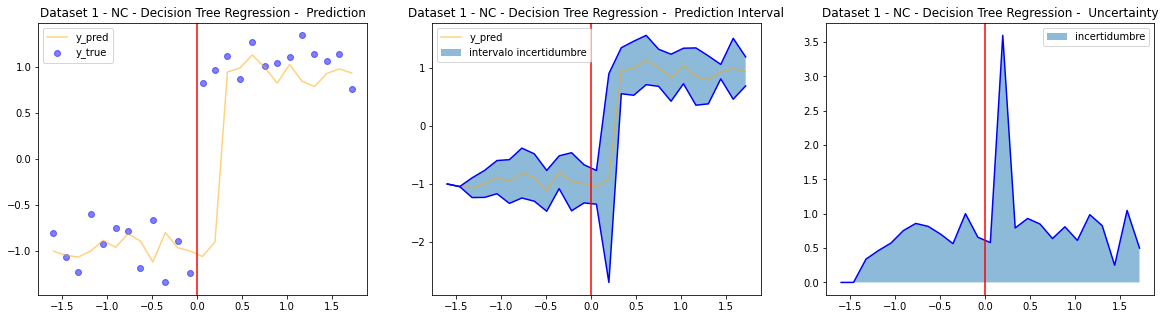

In [25]:
showUncertainty(getUncertaintyByNCOnline(dataset1, model = DecisionTreeRegressor()), drifts=[0], titles=['Dataset 1 - NC - Decision Tree Regression - ', 'Dataset 1 - NC - Decision Tree Regression - ','Dataset 1 - NC - Decision Tree Regression - '])

#### Dataset 2

##### Linear Regression

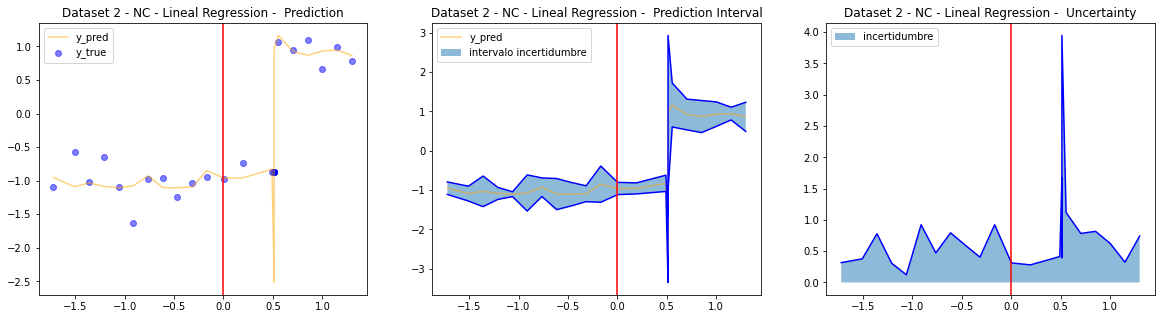

In [26]:
showUncertainty(getUncertaintyByNCOnline(dataset2, model = LinearRegression()), drifts=[0], titles=['Dataset 2 - NC - Lineal Regression - ', 'Dataset 2 - NC - Lineal Regression - ', 'Dataset 2 - NC - Lineal Regression - '])
 

##### PassiveAgressive Regression

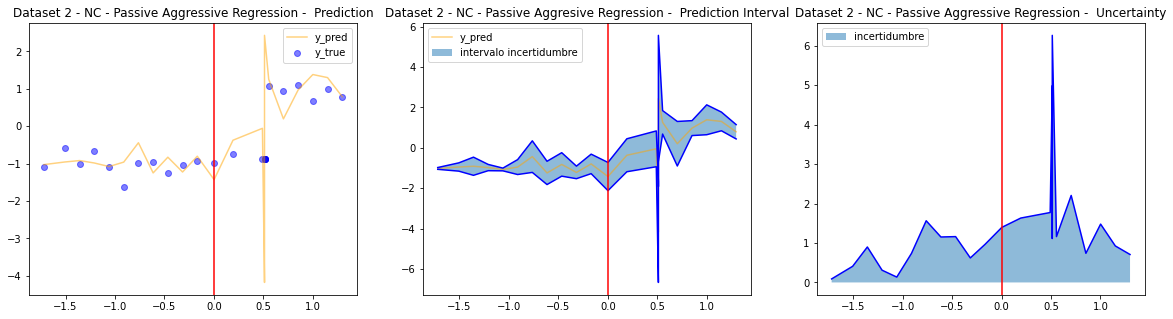

In [27]:
showUncertainty(getUncertaintyByNCOnline(dataset2, model = PassiveAggressiveRegressor()), drifts=[0], titles=['Dataset 2 - NC - Passive Aggressive Regression - ', 'Dataset 2 - NC - Passive Aggresive Regression - ', 'Dataset 2 - NC - Passive Aggressive Regression - '])
 

##### Decision Tree Regressor

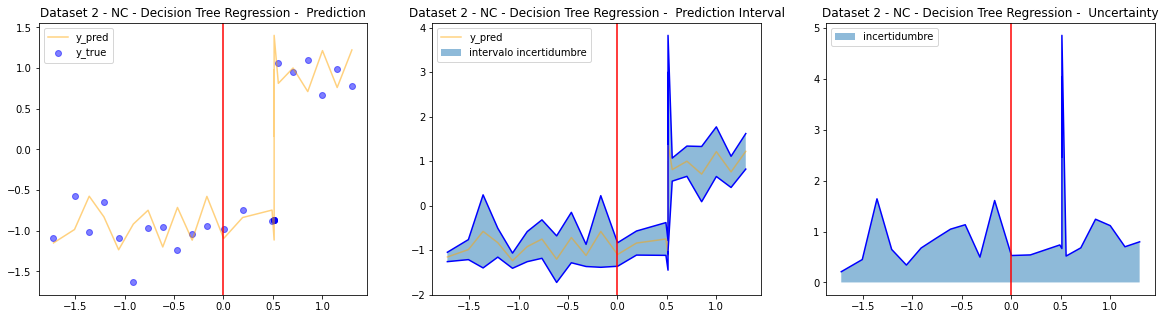

In [28]:
showUncertainty(getUncertaintyByNCOnline(dataset2, model = DecisionTreeRegressor()), drifts=[0], titles=['Dataset 2 - NC - Decision Tree Regression - ', 'Dataset 2 - NC - Decision Tree Regression - ','Dataset 2 - NC - Decision Tree Regression - '])

#### Dataset 3

##### Linear Regression

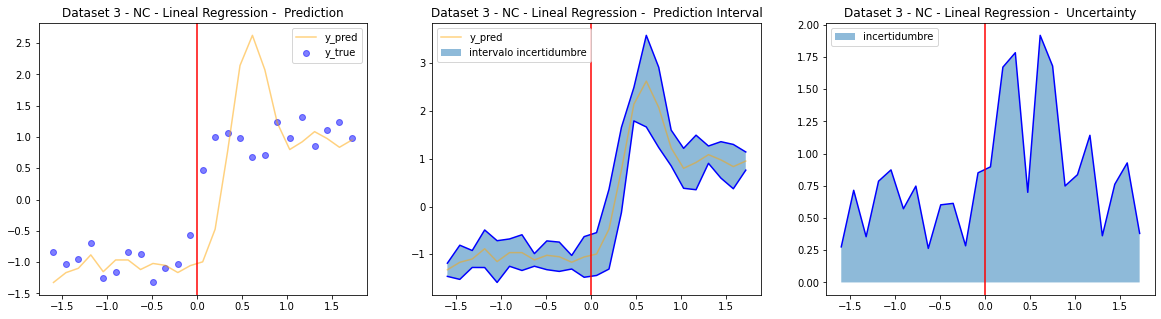

In [29]:
showUncertainty(getUncertaintyByNCOnline(dataset3, model = LinearRegression()), drifts=[0], titles=['Dataset 3 - NC - Lineal Regression - ', 'Dataset 3 - NC - Lineal Regression - ', 'Dataset 3 - NC - Lineal Regression - '])
 

##### PassiveAgressive Regression

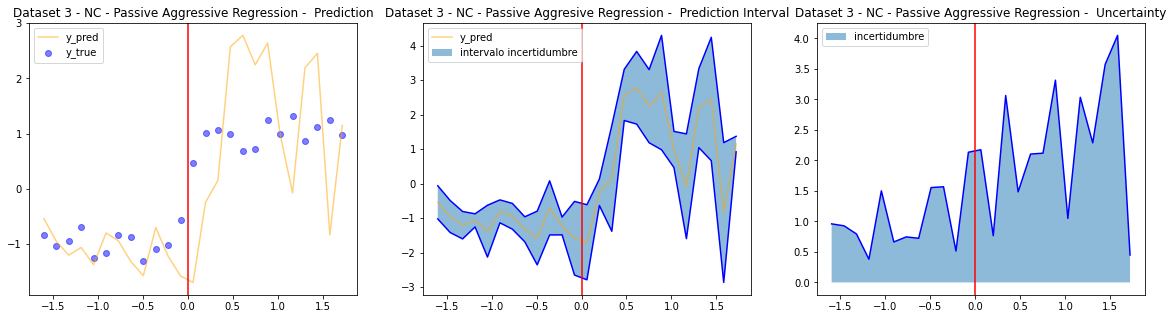

In [30]:
showUncertainty(getUncertaintyByNCOnline(dataset3, model = PassiveAggressiveRegressor()), drifts=[0], titles=['Dataset 3 - NC - Passive Aggressive Regression - ', 'Dataset 3 - NC - Passive Aggresive Regression - ', 'Dataset 3 - NC - Passive Aggressive Regression - '])
 

##### Decision Tree Regressor

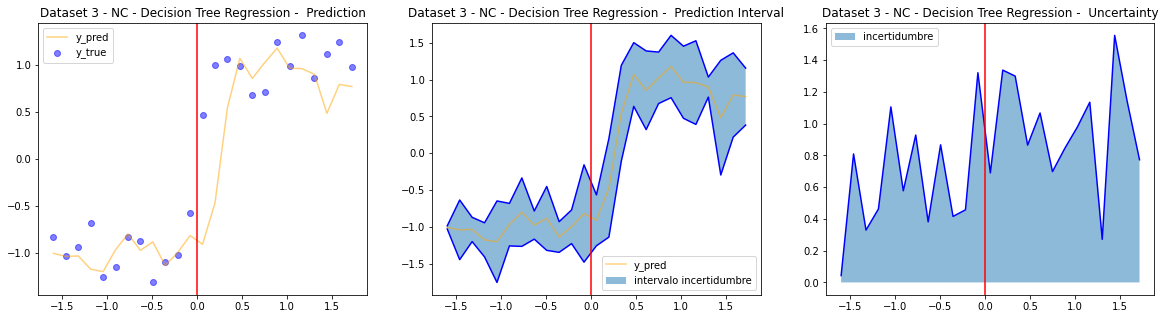

In [31]:
showUncertainty(getUncertaintyByNCOnline(dataset3, model = DecisionTreeRegressor()), drifts=[0], titles=['Dataset 3 - NC - Decision Tree Regression - ', 'Dataset 3 - NC - Decision Tree Regression - ','Dataset 3 - NC - Decision Tree Regression - '])

#### Dataset 4

##### Linear Regression

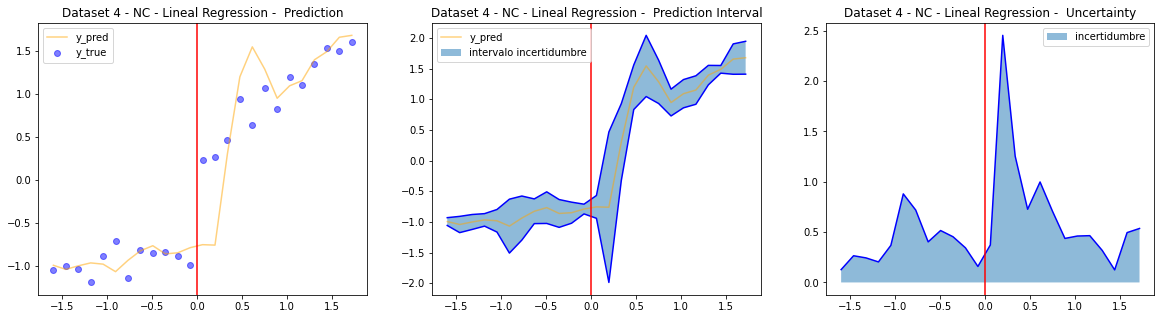

In [32]:
showUncertainty(getUncertaintyByNCOnline(dataset4, model = LinearRegression()), drifts=[0], titles=['Dataset 4 - NC - Lineal Regression - ', 'Dataset 4 - NC - Lineal Regression - ', 'Dataset 4 - NC - Lineal Regression - '])
 

##### PassiveAgressive Regression

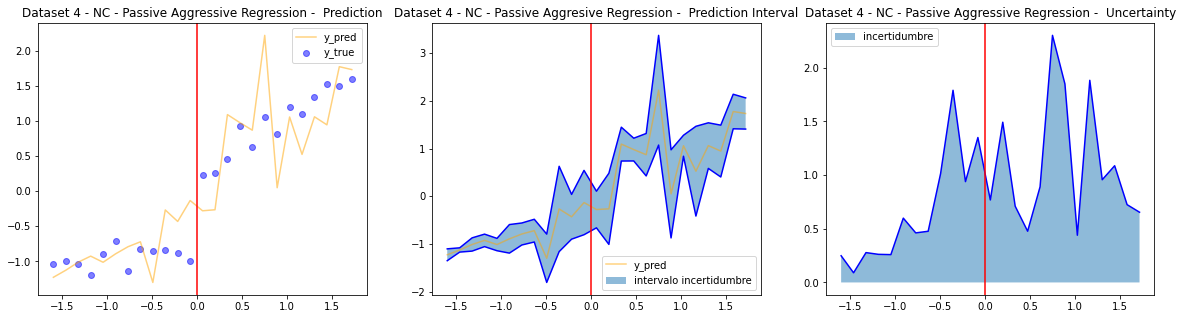

In [33]:
showUncertainty(getUncertaintyByNCOnline(dataset4, model = PassiveAggressiveRegressor()), drifts=[0], titles=['Dataset 4 - NC - Passive Aggressive Regression - ', 'Dataset 4 - NC - Passive Aggresive Regression - ', 'Dataset 4 - NC - Passive Aggressive Regression - '])
 

##### Decision Tree Regressor

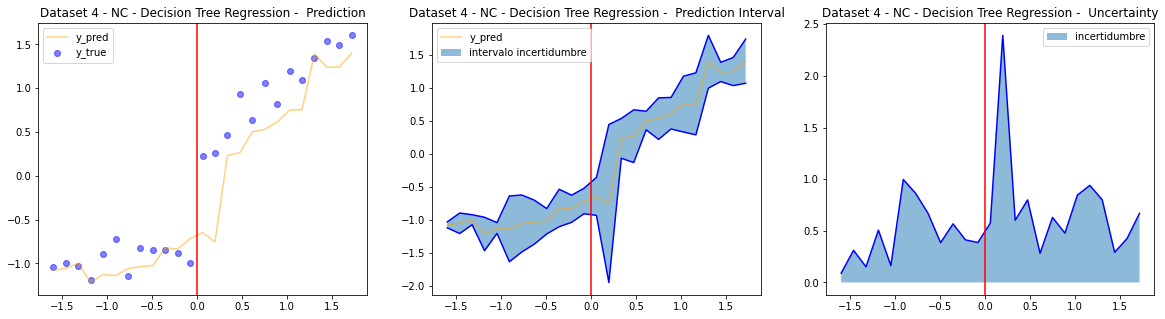

In [34]:
showUncertainty(getUncertaintyByNCOnline(dataset4, model = DecisionTreeRegressor()), drifts=[0], titles=['Dataset 4 - NC - Decision Tree Regression - ', 'Dataset 4 - NC - Decision Tree Regression - ','Dataset 4 - NC - Decision Tree Regression - '])

#### Dataset 5

##### Linear Regression

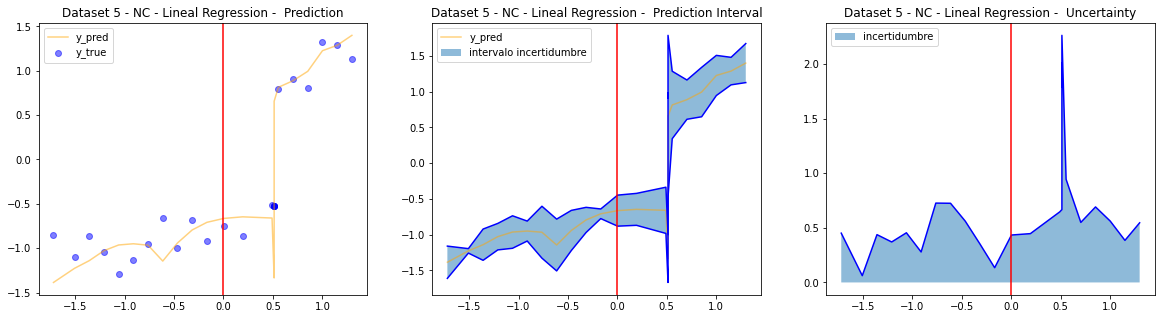

In [35]:
showUncertainty(getUncertaintyByNCOnline(dataset5, model = LinearRegression()), drifts=[0], titles=['Dataset 5 - NC - Lineal Regression - ', 'Dataset 5 - NC - Lineal Regression - ', 'Dataset 5 - NC - Lineal Regression - '])
 

##### PassiveAgressive Regression

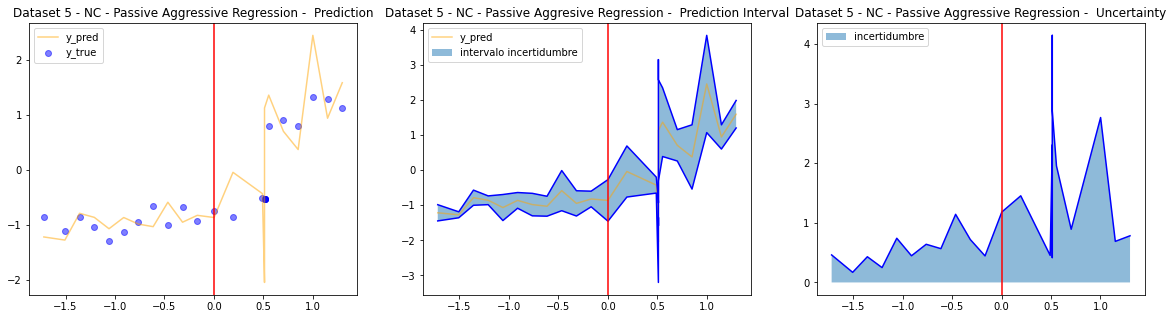

In [36]:
showUncertainty(getUncertaintyByNCOnline(dataset5, model = PassiveAggressiveRegressor()), drifts=[0], titles=['Dataset 5 - NC - Passive Aggressive Regression - ', 'Dataset 5 - NC - Passive Aggresive Regression - ', 'Dataset 5 - NC - Passive Aggressive Regression - '])
 

##### Decision Tree Regressor

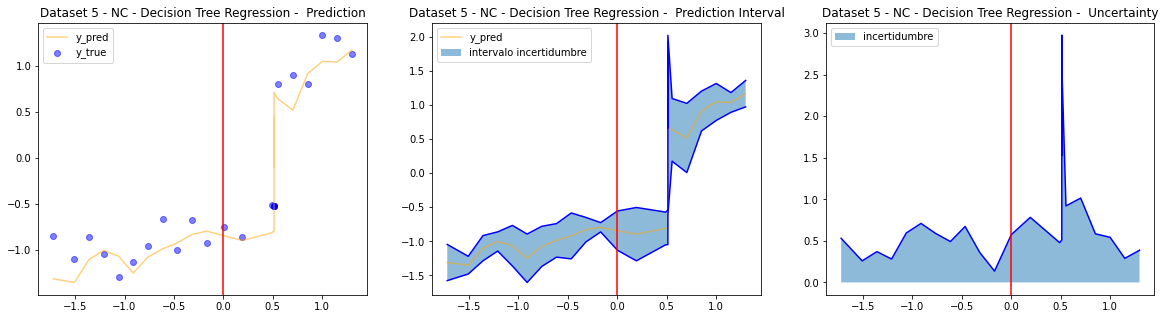

In [37]:
showUncertainty(getUncertaintyByNCOnline(dataset5, model = DecisionTreeRegressor()), drifts=[0], titles=['Dataset 5 - NC - Decision Tree Regression - ', 'Dataset 5 - NC - Decision Tree Regression - ','Dataset 5 - NC - Decision Tree Regression - '])

#### Dataset 6

##### Linear Regression

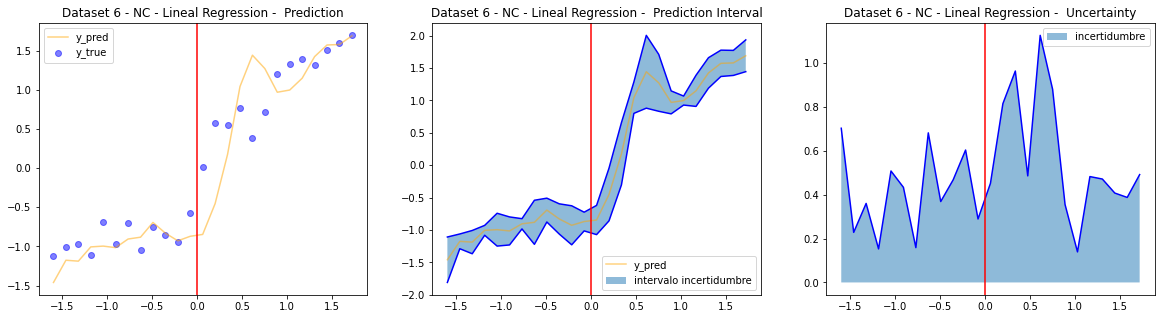

In [38]:
showUncertainty(getUncertaintyByNCOnline(dataset6, model = LinearRegression()), drifts=[0], titles=['Dataset 6 - NC - Lineal Regression - ', 'Dataset 6 - NC - Lineal Regression - ', 'Dataset 6 - NC - Lineal Regression - '])
 

##### PassiveAgressive Regression

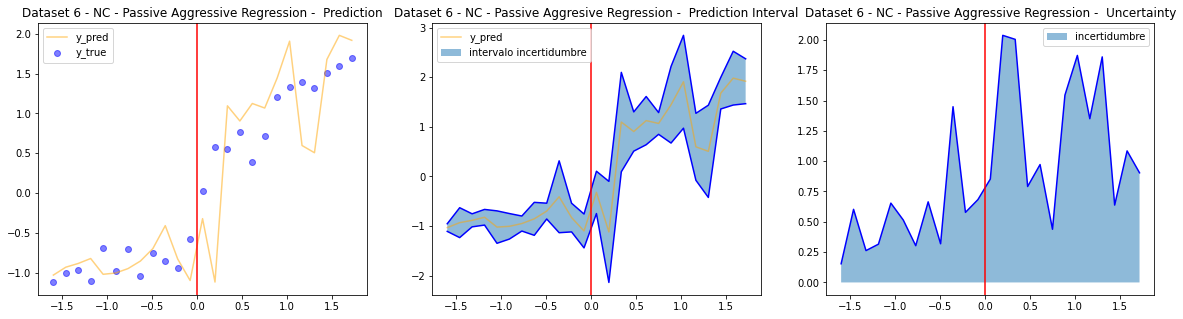

In [39]:
showUncertainty(getUncertaintyByNCOnline(dataset6, model = PassiveAggressiveRegressor()), drifts=[0], titles=['Dataset 6 - NC - Passive Aggressive Regression - ', 'Dataset 6 - NC - Passive Aggresive Regression - ', 'Dataset 6 - NC - Passive Aggressive Regression - '])
 

##### Decision Tree Regressor

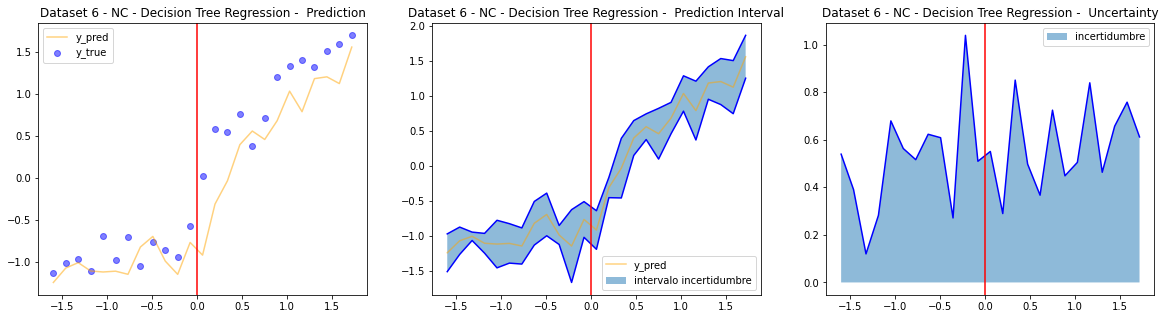

In [40]:
showUncertainty(getUncertaintyByNCOnline(dataset6, model = DecisionTreeRegressor()), drifts=[0], titles=['Dataset 6 - NC - Decision Tree Regression - ', 'Dataset 6 - NC - Decision Tree Regression - ','Dataset 6 - NC - Decision Tree Regression - '])

#### Dataset 7

##### Linear Regression

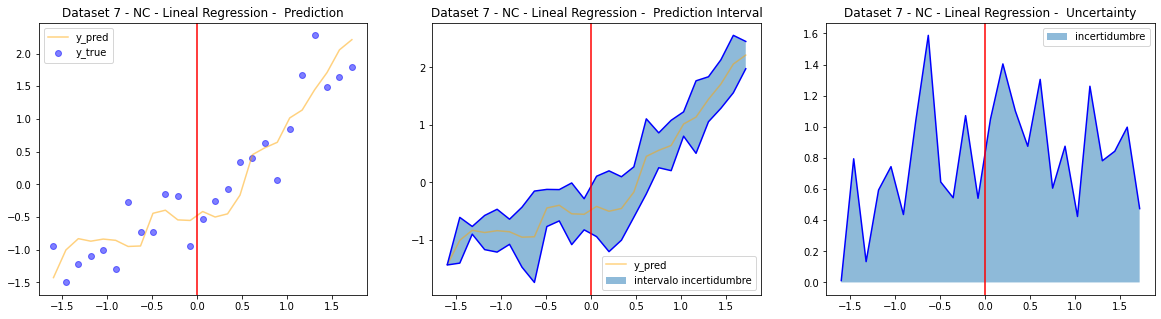

In [41]:
showUncertainty(getUncertaintyByNCOnline(dataset7, model = LinearRegression()), drifts=[0], titles=['Dataset 7 - NC - Lineal Regression - ', 'Dataset 7 - NC - Lineal Regression - ', 'Dataset 7 - NC - Lineal Regression - '])
 

##### PassiveAgressive Regression

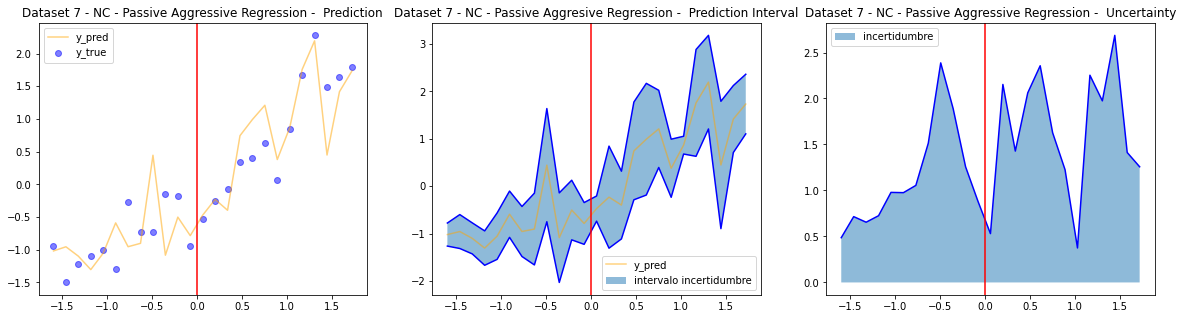

In [42]:
showUncertainty(getUncertaintyByNCOnline(dataset7, model = PassiveAggressiveRegressor()), drifts=[0], titles=['Dataset 7 - NC - Passive Aggressive Regression - ', 'Dataset 7 - NC - Passive Aggresive Regression - ', 'Dataset 7 - NC - Passive Aggressive Regression - '])
 

##### Decision Tree Regressor

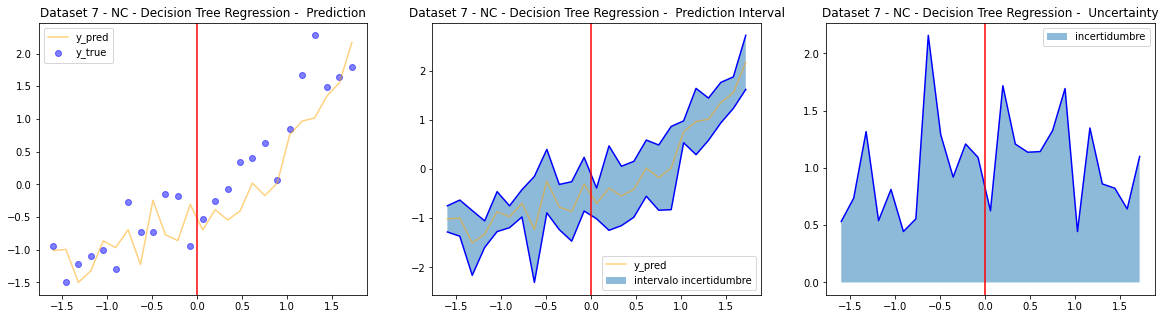

In [43]:
showUncertainty(getUncertaintyByNCOnline(dataset7, model = DecisionTreeRegressor()), drifts=[0], titles=['Dataset 7 - NC - Decision Tree Regression - ', 'Dataset 7 - NC - Decision Tree Regression - ','Dataset 7 - NC - Decision Tree Regression - '])

#### Dataset 8

##### Linear Regression

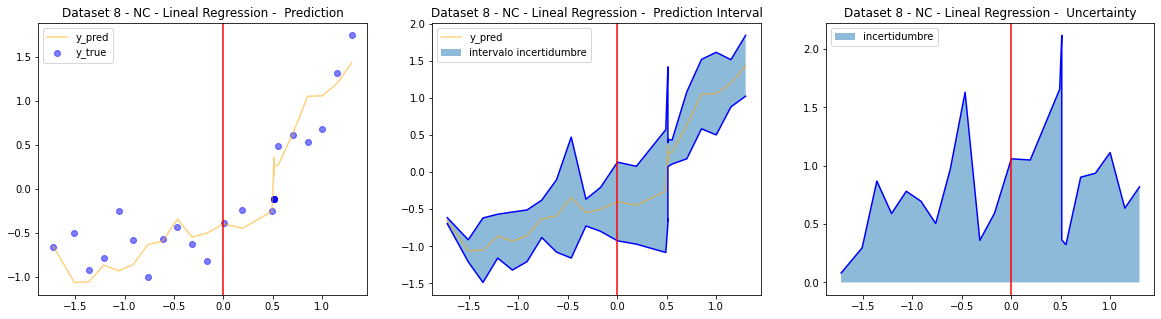

In [44]:
showUncertainty(getUncertaintyByNCOnline(dataset8, model = LinearRegression()), drifts=[0], titles=['Dataset 8 - NC - Lineal Regression - ', 'Dataset 8 - NC - Lineal Regression - ', 'Dataset 8 - NC - Lineal Regression - '])
 

##### PassiveAgressive Regression

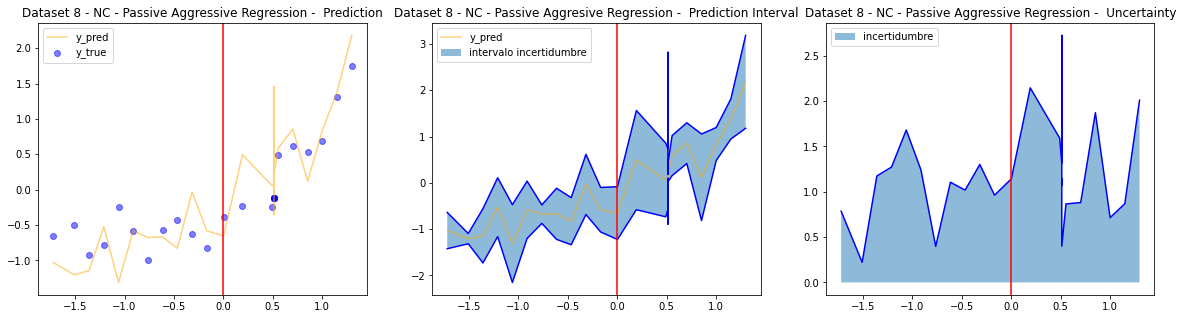

In [45]:
showUncertainty(getUncertaintyByNCOnline(dataset8, model = PassiveAggressiveRegressor()), drifts=[0], titles=['Dataset 8 - NC - Passive Aggressive Regression - ', 'Dataset 8 - NC - Passive Aggresive Regression - ', 'Dataset 8 - NC - Passive Aggressive Regression - '])
 

##### Decision Tree Regressor

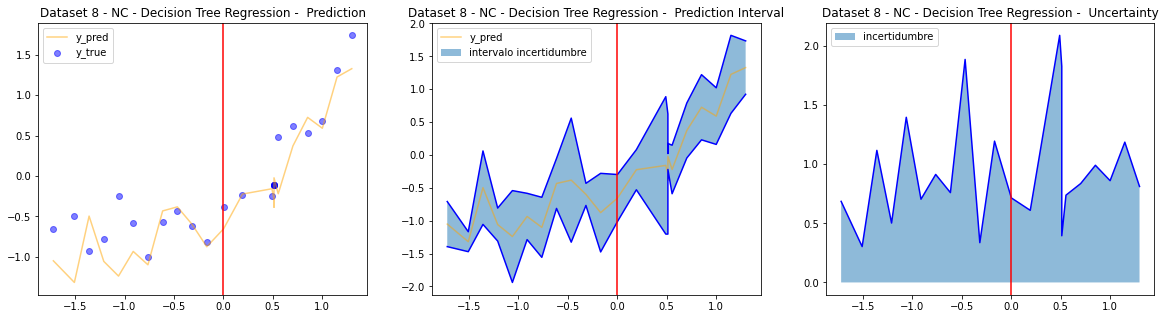

In [46]:
showUncertainty(getUncertaintyByNCOnline(dataset8, model = DecisionTreeRegressor()), drifts=[0], titles=['Dataset 8 - NC - Decision Tree Regression - ', 'Dataset 8 - NC - Decision Tree Regression - ','Dataset 8 - NC - Decision Tree Regression - '])

#### Dataset 9

##### Linear Regression

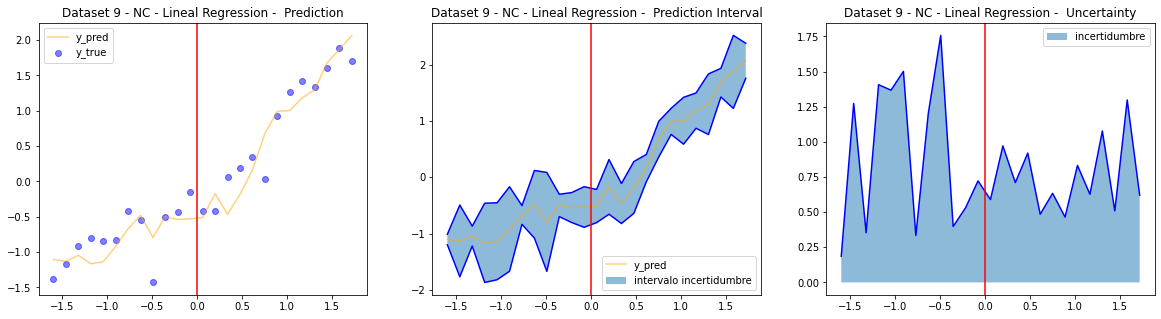

In [47]:
showUncertainty(getUncertaintyByNCOnline(dataset9, model = LinearRegression()), drifts=[0], titles=['Dataset 9 - NC - Lineal Regression - ', 'Dataset 9 - NC - Lineal Regression - ', 'Dataset 9 - NC - Lineal Regression - '])
 

##### PassiveAgressive Regression

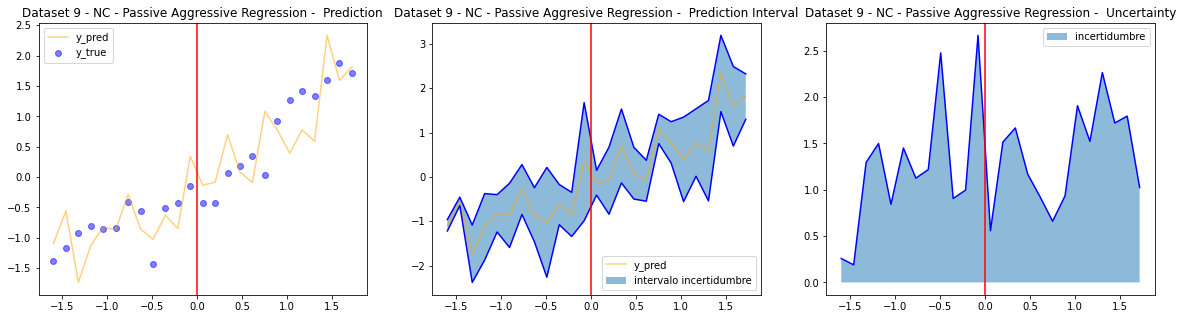

In [48]:
showUncertainty(getUncertaintyByNCOnline(dataset9, model = PassiveAggressiveRegressor()), drifts=[0], titles=['Dataset 9 - NC - Passive Aggressive Regression - ', 'Dataset 9 - NC - Passive Aggresive Regression - ', 'Dataset 9 - NC - Passive Aggressive Regression - '])
 

##### Decision Tree Regressor

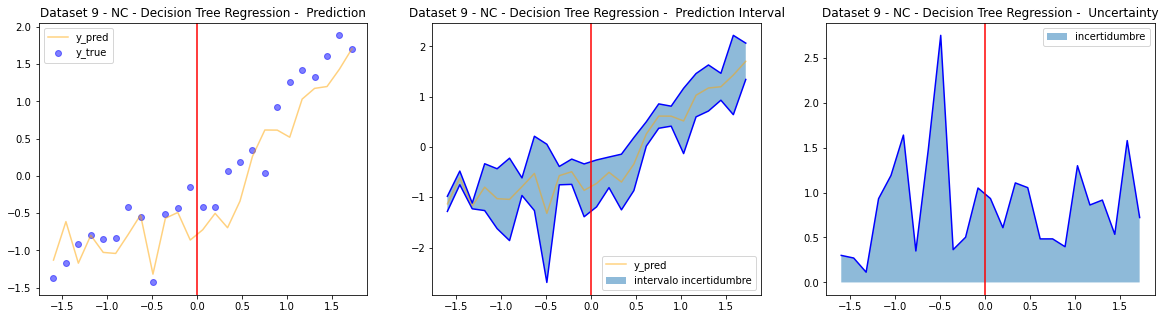

In [49]:
showUncertainty(getUncertaintyByNCOnline(dataset9, model = DecisionTreeRegressor()), drifts=[0], titles=['Dataset 9 - NC - Decision Tree Regression - ', 'Dataset 9 - NC - Decision Tree Regression - ','Dataset 9 - NC - Decision Tree Regression - '])


### Cálculo de la incertidumbre de forma estadística

#### Implementación

In [50]:

# https://towardsdatascience.com/prediction-intervals-in-python-64b992317b1a
class CustomLinearRegression:
    def __init__(self):
        pass
    
    def fit(self, x, y):
        # Calculate stats
        self.n = len(x)
        self.x_mean = np.mean(x)
        self.y_mean = np.mean(y)
        self.x_gap = x-self.x_mean
        self.y_gap = y-self.y_mean
        self.ss = np.square(self.x_gap).sum()
        
        # Find coefficients
        self.slope = np.dot(self.x_gap, self.y_gap)/self.ss
        self.intercept = self.y_mean-self.slope*self.x_mean
        
        # Find training error
        y_pred = self.intercept+self.slope*x
        self.se_regression = np.sqrt(
            np.square(y-y_pred).sum()/(self.n-2)
        )
    
    def predict(self, x):
        y_pred = self.intercept+self.slope*x
        return y_pred
    
    def predict_interval(self, x, alpha=0.05):
        t_stat = t.ppf(1-alpha/2, df=self.n-2)
        
        # Calculate interval upper and lower boundaries
        df = pd.DataFrame({'x': x})
        for i, value in df['x'].iteritems():
            se = self.se_regression * np.sqrt(
                1+1/self.n+np.square(value-self.x_mean)/self.ss
            )
            df.loc[i, 'y_pred'] = self.intercept+self.slope*value
            df.loc[i, 'lower'] = df.loc[i, 'y_pred']-t_stat*se
            df.loc[i, 'upper'] = df.loc[i, 'y_pred']+t_stat*se
        return df

def getUncertaintyByStatistic(dataset):
  custom_model = CustomLinearRegression()     
  sorted_dataset = dataset.sort_values(by=['x'])
  Y = np.array(sorted_dataset['y'].values.tolist()).flatten()
  X = np.array(sorted_dataset.drop(columns='y').values.tolist()).flatten()
  custom_model.fit(X, Y)

  custom_pred = custom_model.predict_interval(X)
  
  return {'x':custom_pred['x'].tolist(), 'y': Y.tolist(), 'uncert95': custom_pred['upper'].tolist(), 'uncert05': custom_pred['lower'].tolist(), 'y_pred': custom_pred['y_pred'].tolist()}

def getUncertaintyByStatisticOnline(dataset):
  count = 25
  dataframes = []
  index_to_split = len(dataset) // count
  start = 0
  end = index_to_split
  for split in range(count):
    temporary_df = dataset.iloc[max(0, start-5*index_to_split):end, :]
    dataframes.append(temporary_df)
    start += index_to_split
    end += index_to_split

  data = list(map(lambda d: getUncertaintyByStatistic(d), dataframes))

  data = list(map(lambda d: {'x': [d['x'][-1]], 'y':[d['y'][-1]], 'uncert95': [d['uncert95'][-1]], 'uncert05': [d['uncert05'][-1]], 'y_pred':[d['y_pred'][-1]] }, data))
  single_data = reduce(mergeDict, data)
  df = pd.DataFrame(single_data)
  return df.sort_values(by=['x'])


#### Dataset 1

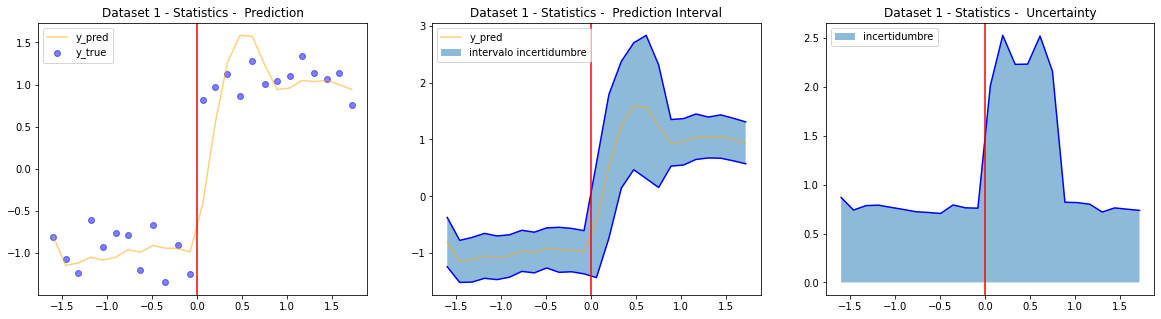

In [51]:
showUncertainty(getUncertaintyByStatisticOnline(dataset1), [0], titles=['Dataset 1 - Statistics - ', 'Dataset 1 - Statistics - ', 'Dataset 1 - Statistics - '])

#### Dataset 2

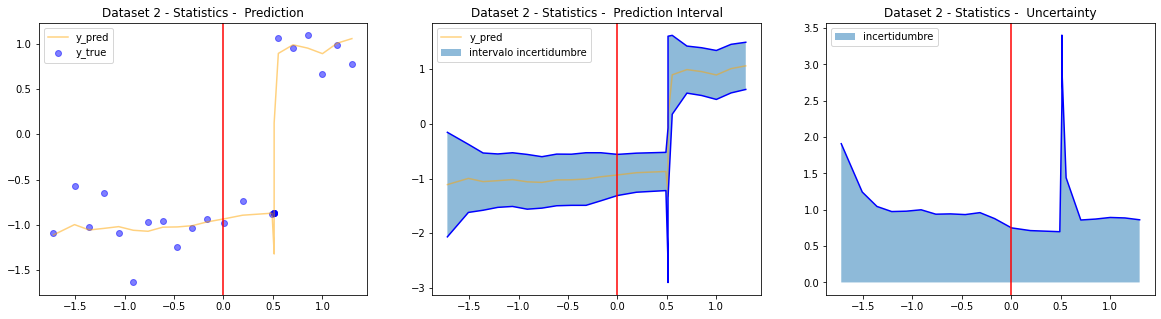

In [52]:
showUncertainty(getUncertaintyByStatisticOnline(dataset2), [0], titles=['Dataset 2 - Statistics - ', 'Dataset 2 - Statistics - ', 'Dataset 2 - Statistics - '])

#### Dataset 3

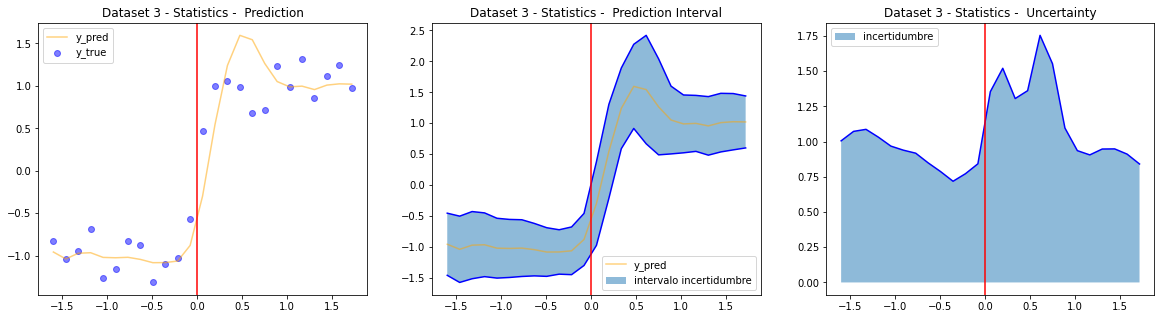

In [53]:
showUncertainty(getUncertaintyByStatisticOnline(dataset3), [0], titles=['Dataset 3 - Statistics - ', 'Dataset 3 - Statistics - ', 'Dataset 3 - Statistics - '])

#### Dataset 4

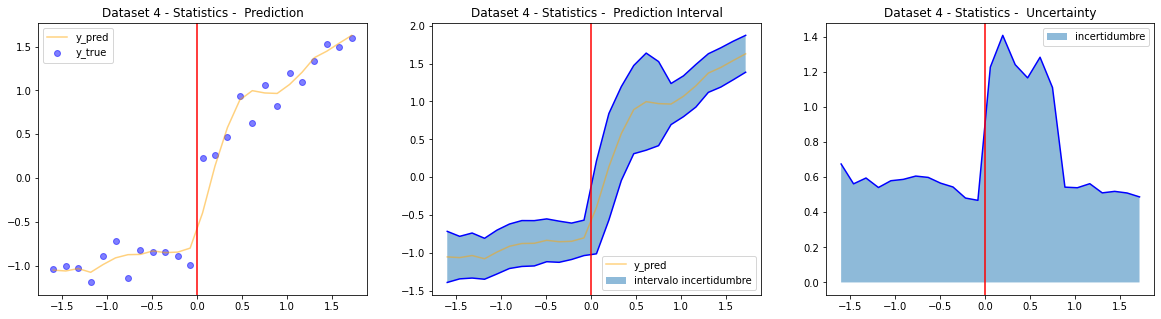

In [54]:
showUncertainty(getUncertaintyByStatisticOnline(dataset4), [0], titles=['Dataset 4 - Statistics - ', 'Dataset 4 - Statistics - ', 'Dataset 4 - Statistics - '])

#### Dataset 5

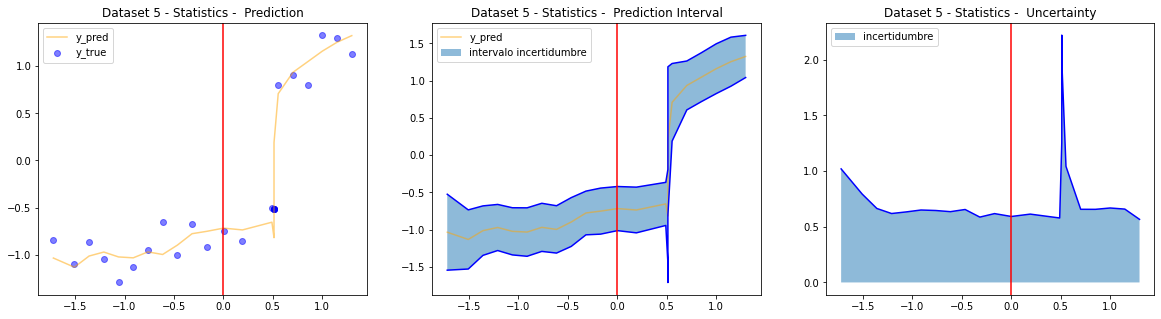

In [55]:
showUncertainty(getUncertaintyByStatisticOnline(dataset5), [0], titles=['Dataset 5 - Statistics - ', 'Dataset 5 - Statistics - ', 'Dataset 5 - Statistics - '])

#### Dataset 6

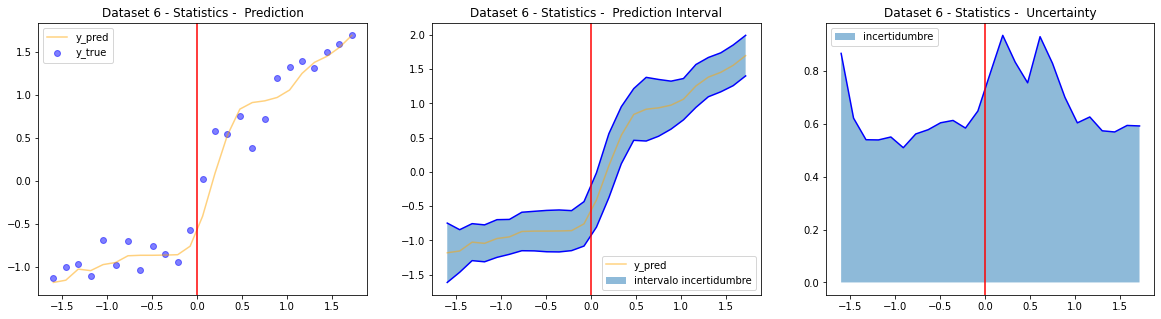

In [56]:
showUncertainty(getUncertaintyByStatisticOnline(dataset6), [0], titles=['Dataset 6 - Statistics - ', 'Dataset 6 - Statistics - ', 'Dataset 6 - Statistics - '])

#### Dataset 7

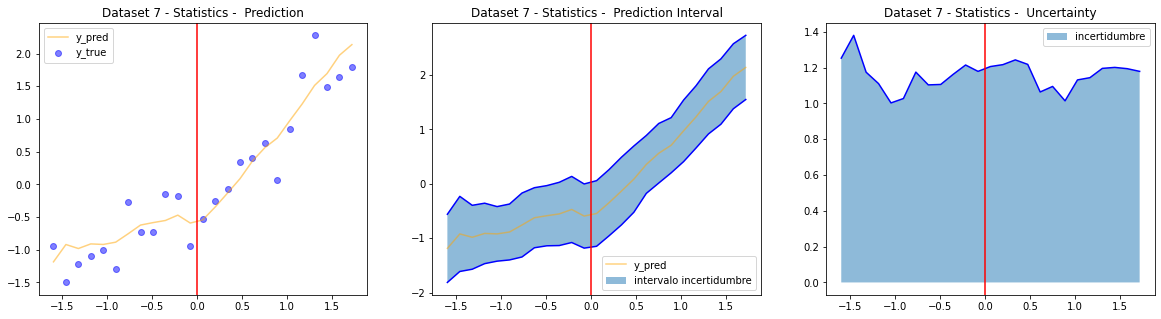

In [57]:
showUncertainty(getUncertaintyByStatisticOnline(dataset7), [0], titles=['Dataset 7 - Statistics - ', 'Dataset 7 - Statistics - ', 'Dataset 7 - Statistics - '])

#### Dataset 8

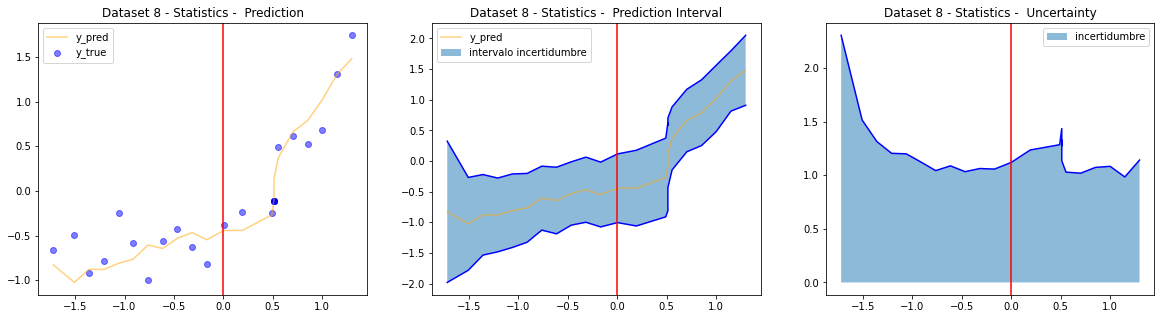

In [58]:
showUncertainty(getUncertaintyByStatisticOnline(dataset8), [0], titles=['Dataset 8 - Statistics - ', 'Dataset 8 - Statistics - ', 'Dataset 8 - Statistics - '])

#### Dataset 9

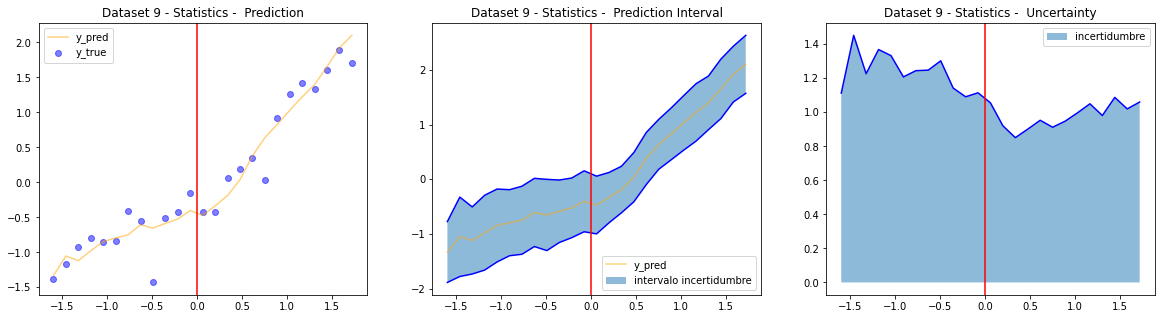

In [59]:
showUncertainty(getUncertaintyByStatisticOnline(dataset9), [0], titles=['Dataset 9 - Statistics - ', 'Dataset 9 - Statistics - ', 'Dataset 9 - Statistics - '])